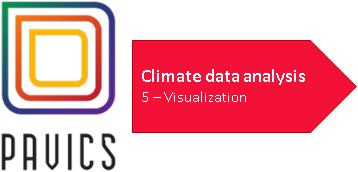
<a id='top'></a>

ADD descr. 

This tutorial outlines steps for visualizing and summarizing climate data into usable information and visualizatinons including:

* [Maps of climate normals](#maps)
* [Time-series plots](#timeseries)
* [Table summaries](#tables)

___

*NOTE : To run this series of tutorials in the PAVICS jupyterhub, notebooks should be copied into your 'writable-workspace' directory*  





## Ensemble dataset preparation
We will re-use the concepts of the ensembles tutorial in a slightly more complex workflow to prepare a dataset containing climate indicator output of both RCP 4.5 and RCP 8.5 simulations

*[return to top of page](#top)*

In [1]:
# Sub function definitions
def unstack_yr_season(ds):
    """Translate resampled data to a multi-index year [int] / season [string]"""
    
    ind = pd.MultiIndex.from_arrays([ds.time.dt.year.values + (ds.time.dt.month.values == 12).astype(int),
                                          ds.time.dt.month.values],
                                         names=['year', 'season'])
    dsout = ds.assign(time=ind).unstack('time')
    if len(pd.unique(dsout.season.values)) == 12:
        seas_label = [calendar.month_name[m] for m in range(1,13)]
    else:
        all_labels = {1: 'Annual', 3: 'Spring', 6: 'Summer', 7: 'Annual (jul-jun)', 9: 'Fall', 12: 'Winter'}
        seas_label = [all_labels[m] for m in pd.unique(dsout.season.values)]
    return dsout.assign_coords(season=seas_label)


In [64]:
from xclim import ensembles as xens
import pandas as pd
from clisops.core import subset
import xarray as xr
from pathlib import Path
import numpy as np

import panel as pn
import holoviews as hv
from holoviews import streams
import hvplot
import hvplot.pandas
import hvplot.xarray
from bokeh.models.tools import HoverTool
import warnings
import logging

logging.getLogger().disabled = True
warnings.simplefilter("ignore")

infolder = Path('output')

ds_all =[]
for rcp in ['rcp45','rcp85']:
    ncfiles = [d for d in infolder.glob(f'*{rcp}*.nc')]
    
    #Create an ensemble dataset from the 11 simulations for the given rcp
    # Add a new rcp dimension and corodinate
    ds = xens.create_ensemble(ncfiles).assign_coords(rcp=rcp).expand_dims('rcp')
    ds_all.append(ds)

#concatenate the 2 rcp datasets together along the new 'rcp' dim
ds_ens = xr.concat(ds_all, dim='rcp')
ds_ens

<xarray.Dataset>
Dimensions:        (lat: 12, lon: 60, rcp: 2, realization: 11, time: 481)
Coordinates:
  * time           (time) datetime64[ns] 1980-12-01 1981-03-01 ... 2100-12-01
  * lat            (lat) float32 48.96 48.87 48.79 48.71 ... 48.21 48.12 48.04
  * lon            (lon) float32 -68.96 -68.88 -68.8 ... -64.21 -64.13 -64.05
  * realization    (realization) int64 0 1 2 3 4 5 6 7 8 9 10
  * rcp            (rcp) object 'rcp45' 'rcp85'
Data variables:
    tx_days_above  (rcp, realization, time, lat, lon) float64 dask.array<chunksize=(1, 1, 481, 12, 60), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.5
    title:                      Ouranos standard ensemble of bias-adjusted cl...
    history:                    CMIP5 compliant file produced from raw ACCESS...
    institution:                Ouranos Consortium on Regional Climatology an...
    source:                     ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 gr...
    driving_model:              ACCESS1-3
    driving_experiment:         historical,rcp45
    institute_id:               Ouranos
    type:                       GCM
    processing:                 bias_adjusted
    dataset_description:        https://www.ouranos.ca/publication-scientifiq...
    bias_adjustment_method:     1D-Quantile Mapping
    bias_adjustment_reference:  http://doi.org/10.1002/2015JD023890
    project_id:                 CMIP5
    licence_type:               permissive
    terms_of_use:               Terms of use at https://www.ouranos.ca/climat...
    attribution:                Use of this dataset should be acknowledged as...
    frequency:                  day
    modeling_realm:             atmos
    target_dataset:             CANADA : ANUSPLIN interpolated Canada daily 3...
    target_dataset_references:  CANADA : https://doi.org/10.1175/2011BAMS3132...
    driving_institution:        Commonwealth Scientific and Industrial Resear...
    driving_institute_id:       CSIRO-BOM

<a id='maps'></a>
## Maps of climate normals
In this section we examine steps to : 1) Calculate 30 year climatologies on our ensemble datasets
2) Calculate delta change values with respect to a reference period and 3) Create an interactive figure to explore the data

Notes:
* "Unstacking" the time dimension will allow us to run 30 year averages for all seasons simultaneously with `xarray` operations such as [rolling](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.rolling.html) or [coarsen](https://xarray.pydata.org/en/v0.12.0/generated/xarray.Dataset.coarsen.html)

*[return to top of page](#top)*

In [128]:
ds2d = unstack_yr_season(ds_ens)
ds2d
window = 30
d30yAvg = ds2d.rolling(year=window).mean().sel(year=slice(ds2d.year[0]+window-1,2100))
horizons = xr.DataArray([f'{yr - 29}-{yr}' for yr in d30yAvg.year.values], dims=dict(year=d30yAvg.year))
d30yAvg = d30yAvg.assign_coords(horizon=horizons)
# Select every horizons in 10 y intervals
d30yAvg = d30yAvg.sel(year=(d30yAvg.year.values%10==0))
# Calculate deltas
ref = d30yAvg.sel(year=(d30yAvg.horizon=='1981-2010')).squeeze()
for v in d30yAvg.data_vars:
    with xr.set_options(keep_attrs=True):
        d30yAvg[f"{v}_delta"]= d30yAvg[v] - ref[v]
        for a in ['description', 'long_name']:
            d30yAvg[f"{v}_delta"].attrs[a] = f"{d30yAvg[f'{v}_delta'].attrs[a]} : delta vs 1981-2010"
        

# Calculate percentiles on 30y normals
d30yAvg = xens.ensemble_percentiles(d30yAvg, split=False).load()

# Create interactive map using holoviz tools
css = '''
.bk.panel-widget-box {
  border: 1px black solid;
}
'''
# widgets setup
vars = pn.widgets.Select(options=list(d30yAvg.data_vars.keys()), width=200)
vars1 = pn.Column(pn.pane.Markdown('**Variable**'),vars)
seasons = pn.widgets.Select(options=list(d30yAvg.season.values), value='Summer', width=200)
seasons1 = pn.Column(pn.pane.Markdown('**Season**'),seasons)
perc = pn.widgets.RadioButtonGroup(options=list(d30yAvg.percentiles.values), value=50, width=200)
perc1 = pn.Column(pn.pane.Markdown('**Ensemble Percentile**'),perc)
hors = pn.widgets.DiscreteSlider(options=list(d30yAvg.horizon.values), value='2041-2070')
hors1 = pn.Column(pn.pane.Markdown('**Horizon**'),hors)
rcps = pn.widgets.RadioButtonGroup(options=list(d30yAvg.rcp.values), value='rcp85', width=200)
rcps1 = pn.Column(pn.pane.Markdown('**Emissions scenario**'),rcps)


# Dynamically change maps using pn.depends decorator
@pn.depends(vars.param.value, seasons.param.value, perc.param.value, hors.param.value, rcps.param.value)
def plot_map(v=vars.param.value, s=seasons.param.value, p=perc.param.value, h=hors.param.value, r=rcps.param.value):   
    clim = (d30yAvg[v].sel(season=s).min().values, d30yAvg[v].sel(season=s).max().values)
    out = d30yAvg.swap_dims(dict(year='horizon')).sel(season=s, percentiles=p, horizon=h, rcp=r)
    
    hover = HoverTool(tooltips=[(out[v].attrs['long_name'], f"@{v}")])
    title = pn.pane.Markdown(f"### {out[v].attrs['description']}")
    return pn.Column(title,out.hvplot.quadmesh(alpha=0.75,xlabel='lon',ylabel='lat',z=v, cmap='RdBu_r', clim=clim, geo=True, tiles='CartoLight', tools=[hover],frame_width=1200))

#Display interactive map
display()
pn.Column(plot_map, pn.Column(pn.Row(vars1, seasons1, rcps1, perc1),hors1,))


Column
    [0] ParamFunction(function)
    [1] Column
        [0] Row
            [0] Column
                [0] Markdown(str)
                [1] Select(options=['tx_days_above', ...], value='tx_days_above', width=200)
            [1] Column
                [0] Markdown(str)
                [1] Select(options=['Spring', 'Summer', ...], value='Summer', width=200)
            [2] Column
                [0] Markdown(str)
                [1] RadioButtonGroup(options=['rcp45', 'rcp85'], value='rcp85', width=200)
            [3] Column
                [0] Markdown(str)
                [1] RadioButtonGroup(options=[10, 50, 90], value=50, width=200)
        [1] Column
            [0] Markdown(str)
            [1] DiscreteSlider(options=['1981-2010', ...], value='2041-2070', value_throttled='2041-2070')

___


In [11]:

d30yAvg

<xarray.Dataset>
Dimensions:              (lat: 12, lon: 60, percentiles: 3, rcp: 2, season: 4, year: 10)
Coordinates:
  * lat                  (lat) float32 48.96 48.87 48.79 ... 48.21 48.12 48.04
  * lon                  (lon) float32 -68.96 -68.88 -68.8 ... -64.13 -64.05
  * rcp                  (rcp) object 'rcp45' 'rcp85'
  * year                 (year) int64 2010 2020 2030 2040 ... 2080 2090 2100
  * season               (season) <U6 'Spring' 'Summer' 'Fall' 'Winter'
    horizon              (year) <U9 '1981-2010' '1991-2020' ... '2071-2100'
  * percentiles          (percentiles) int64 10 50 90
Data variables:
    tx_days_above        (rcp, lat, lon, year, season, percentiles) float64 0...
    tx_days_above_delta  (rcp, lat, lon, year, season, percentiles) float64 0...
Attributes:
    Conventions:                CF-1.5
    title:                      Ouranos standard ensemble of bias-adjusted cl...
    history:                    CMIP5 compliant file produced from raw ACCESS...
    institution:                Ouranos Consortium on Regional Climatology an...
    source:                     ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 gr...
    driving_model:              ACCESS1-3
    driving_experiment:         historical,rcp45
    institute_id:               Ouranos
    type:                       GCM
    processing:                 bias_adjusted
    dataset_description:        https://www.ouranos.ca/publication-scientifiq...
    bias_adjustment_method:     1D-Quantile Mapping
    bias_adjustment_reference:  http://doi.org/10.1002/2015JD023890
    project_id:                 CMIP5
    licence_type:               permissive
    terms_of_use:               Terms of use at https://www.ouranos.ca/climat...
    attribution:                Use of this dataset should be acknowledged as...
    frequency:                  day
    modeling_realm:             atmos
    target_dataset:             CANADA : ANUSPLIN interpolated Canada daily 3...
    target_dataset_references:  CANADA : https://doi.org/10.1175/2011BAMS3132...
    driving_institution:        Commonwealth Scientific and Industrial Resear...
    driving_institute_id:       CSIRO-BOM
    xclim_history:              CMIP5 compliant file produced from raw ACCESS...

In [ ]:
year = pn.widgets.DiscreteSlider(name='year', options = [y for y in d30yAvg.values])
month = pn.widgets.DiscreteSlider(name='month', options=[m for m in ds['rcp45'].month.values])
rcps = pn.widgets.RadioButtonGroup(
    name='RCP', options=['RCP 4.5', 'RCP 8.5'], button_type='success')
variables = pn.widgets.Select(name='percentile', options = [v for v in ds['rcp45'].data_vars])
@pn.depends(year.param.value, month.param.value, variables.param.value, rcps.param.value)
def plot_map(year=year, month=month, variable=variables.param.value, rcp=rcps.param.value):
    rcp = rcp.lower().replace(' ','').replace('.','')
    return ds[rcp][variable].sel(year=year, month=month).hvplot.quadmesh(x='lon',y='lat', title=f'{year}-{year+29}')
@pn.depends( month.param.value, rcps.param.value)
def plot_reference_map(month=month, rcp=rcps.param.value):
    rcp = rcp.lower().replace(' ','').replace('.','')
    variable = [v for v in ds[rcp].data_vars if 'p50' in v][0]
    return ds[rcp][variable].sel(year=1981, month=month).hvplot.quadmesh(x='lon',y='lat',title='Reference Period : 1981-2010')
pn.Row(pn.WidgetBox(rcps, year, month, variables),plot_reference_map, plot_map)

In [ ]:
ds


In [ ]:
ds2d

In [ ]:
ds_ens


___
<a id='ens_stat'></a>
### Ensemble statistics
We can now employ functions for calculating statistics between realizations including calculating [ensemble percentiles](https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html#Ensemble-percentiles) as well as [ensemble mean, standard-deviation, maximum & minimum](https://xclim.readthedocs.io/en/stable/notebooks/ensembles.html#Ensemble-statistics) values
  

*[return to top of page](#top)*

In [ ]:
# Calculate percentiles
ds_perc = xens.ensemble_percentiles(ds_ens, values=[10, 50, 90], split=False)
display(ds_perc)
# compare with indiviudual runs
subset.subset_gridpoint(ds_ens, lon=lon, lat=lat).tx_days_above.plot.line(label='individual runs',color=[0.6, .6 , .6],figsize=(10,5),x='time' ,linewidth=0.5)
perc1 = subset.subset_gridpoint(ds_perc, lon=lon, lat=lat).tx_days_above

plt.fill_between(color='b',label="RCP 4.5 : 10th - 90th percentile",x=perc1.time.values, y1=perc1.sel(percentiles=10), y2=perc1.sel(percentiles=90), alpha=0.2)
subset.subset_gridpoint(ds_perc, lon=lon, lat=lat).tx_days_above.sel(percentiles=50).plot(label="RCP 4.5 : 50th percentile",color='b', linewidth=.85, )

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('RCP 4.5 ensembles percentiles vs individual runs')
display()

___

<a id='ens_metric'></a>
### Ensemble robustness metrics
PAVICS [robustness metrics](https://xclim.readthedocs.io/en/stable/api.html#ensemble-robustness-metrics) can be used to estimate the confidence of the climate change signal. Currently a small number of metrics are implemented based on the IPCC's fifth assessment report : [IPCC AR5 WG1 - chapter 12](https://www.ipcc.ch/site/assets/uploads/2018/02/WG1AR5_Chapter12_FINAL.pdf) (see box 12.1) 


*[return to top of page](#top)*

In [ ]:
fut = ds_ens.sel(time=slice('2071', '2100')).chunk(dict(realization=-1)) 
ref = ds_ens.sel(time=slice('1990', '2020')).chunk(dict(realization=-1))
chng_f, pos_f = xens.change_significance(fut, ref, test='ttest')
plt.figure(figsize=(15,6),)

plt.subplot(1,2,1)
chng_f.tx_days_above.plot(cmap='RdBu_r', vmin=0, vmax=1)

plt.title(chng_f.description.split('.')[0])

plt.subplot(1,2,2)
pos_f.tx_days_above.plot(cmap='RdBu_r', vmin=0, vmax=1)
plt.title(pos_f.description.split('.')[0])

display()